# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
np = torch._np
import matplotlib.pyplot as plt

import os
import yaml

from lfads_sim import LFADS_Net
from utils import read_data, load_parameters, save_parameters
import scipy.io
# plt.style.use('dark_background')

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [3]:
all_time =3000
Time = 20
neuron_num = 30
datax = scipy.io.loadmat("spike30_sim_3000.mat")
y_data = datax["spike30_sim_3000"][:,:all_time]
traj = scipy.io.loadmat("trj30_sim_3000.mat")
traj = traj["trj30_sim_3000"][:,:all_time]
NRep=int(all_time/Time)
output = np.zeros((NRep,Time,neuron_num))
print(y_data.shape)
for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
output = output.astype('float32')
output = torch.Tensor(output).to(device)
print(output.shape)
output_valid = output.detach().clone()

(3000, 30)
torch.Size([150, 20, 30])


## View example Ground Truth Firing Rates

(20, 30)


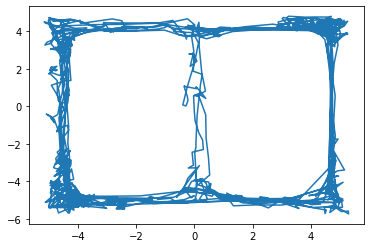

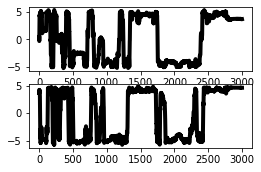

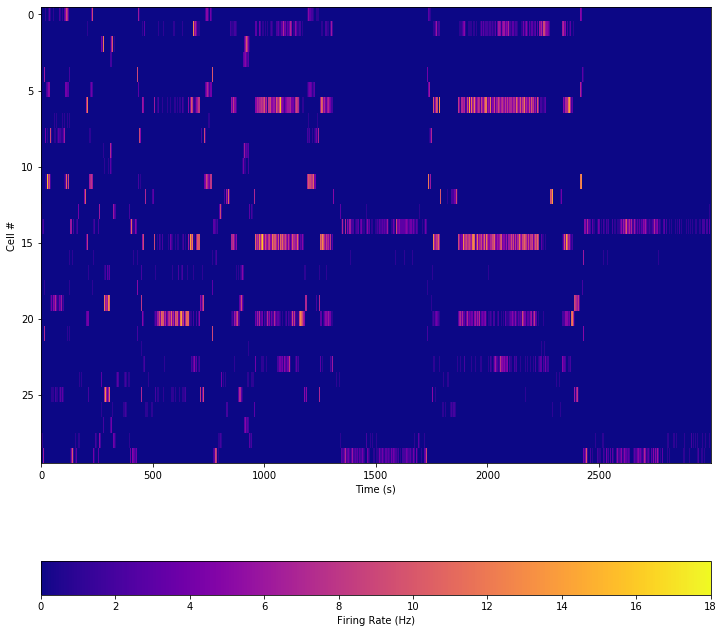

In [4]:
train_ds      = torch.utils.data.TensorDataset(output)
valid_ds      = torch.utils.data.TensorDataset(output)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)
plt.figure(figsize = (12,12))
plt.imshow(y_data.T, cmap=plt.cm.plasma,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')

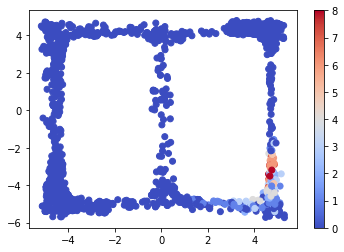

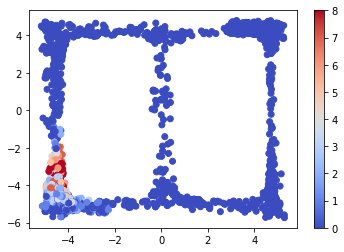

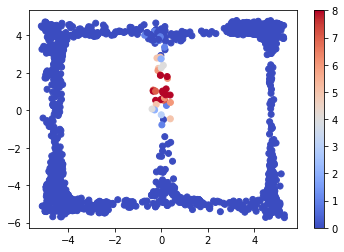

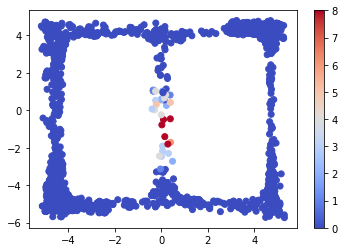

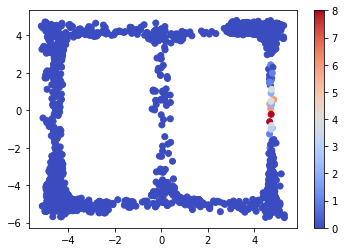

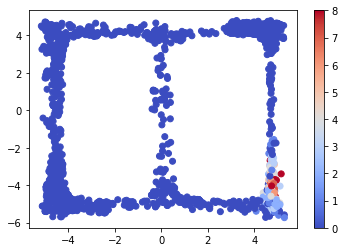

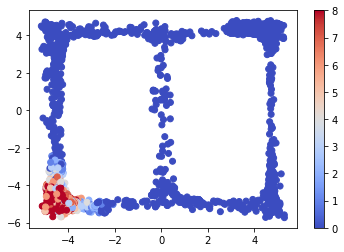

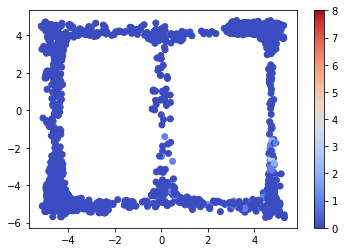

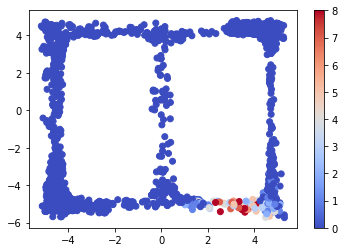

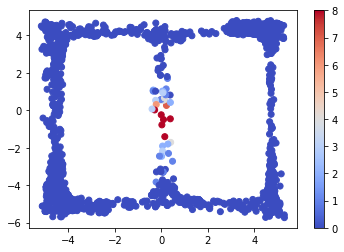

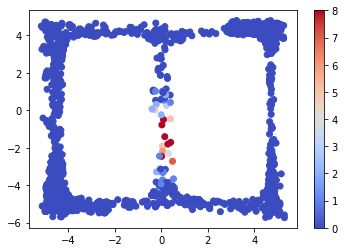

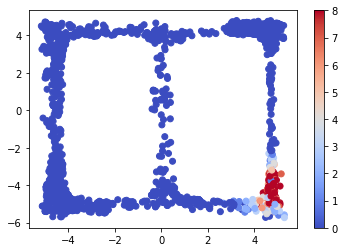

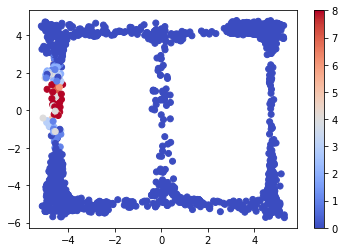

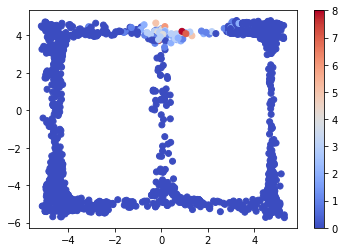

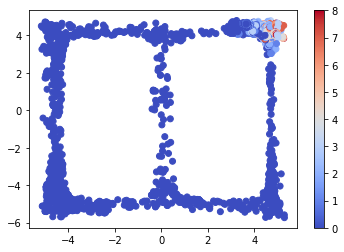

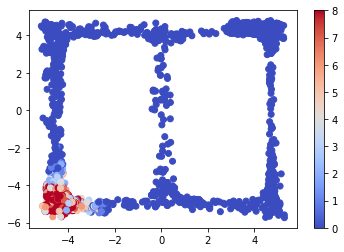

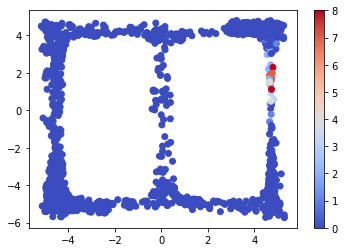

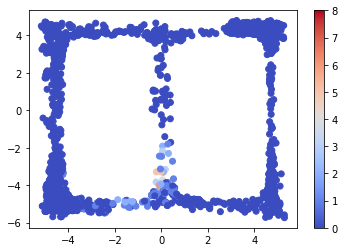

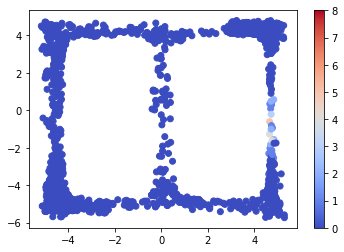

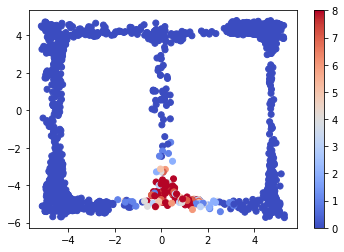

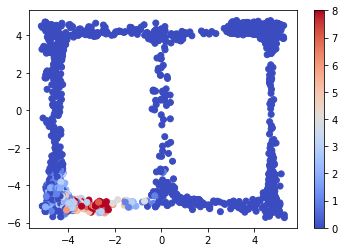

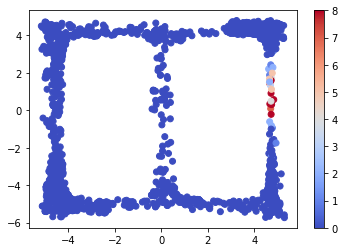

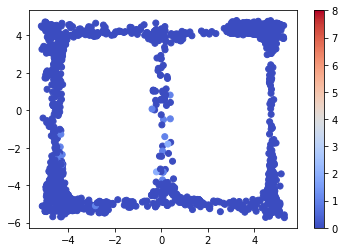

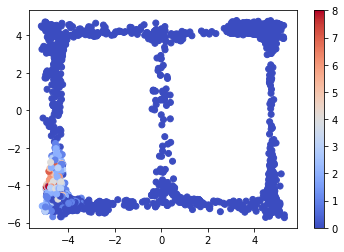

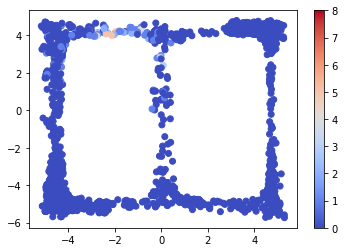

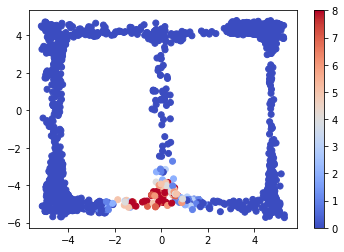

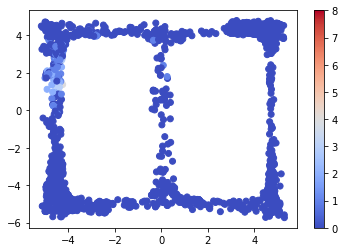

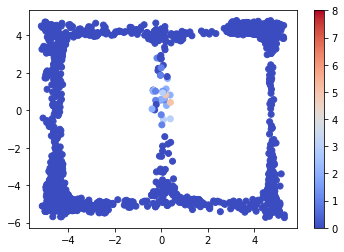

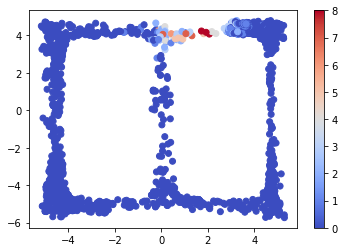

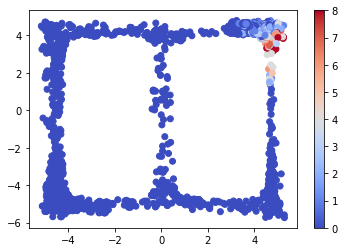

In [5]:
for i in range(neuron_num):
    fig, ax = plt.subplots()
    mappable = ax.scatter(traj[:,0], traj[:,1], c=y_data[:,i] ,cmap='coolwarm',vmin=0,vmax=8)
    fig.colorbar(mappable)
    plt.show()
fig.savefig("img.png")

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [6]:
hyperparams = load_parameters('./parameters.yaml')
save_parameters(hyperparams)
hyperparams

{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 50,
 'u_dim': 1,
 'factors_dim': 2,
 'g0_encoder_dim': 50,
 'c_encoder_dim': 128,
 'controller_dim': 128,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.01,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.95,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [7]:
model = LFADS_Net(inputs_dim = neuron_num, T = Time, dt = 1, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 5519


#### Pick up where you left off (if you have a recent save) 

In [8]:
# model.load_checkpoint('recent')
batch_size = 1
"""tt = np.empty((3000,2))
for k in range(10):
    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(t[90].shape)
    for i in range(batch_size):
        for j in range(100):
            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()
plt.figure()
plt.plot(tt)"""

"tt = np.empty((3000,2))\nfor k in range(10):\n    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])\n    #print(t[90].shape)\n    for i in range(batch_size):\n        for j in range(100):\n            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()\nplt.figure()\nplt.plot(tt)"

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

Beginning training...
Epoch:    1, Step:   150, training loss: 538.823
Epoch:    2, Step:   300, training loss: 361.885
Epoch:    3, Step:   450, training loss: 330.037
Epoch:    4, Step:   600, training loss: 311.170
Epoch:    5, Step:   750, training loss: 313.468
Epoch:    6, Step:   900, training loss: 304.093
Epoch:    7, Step:  1050, training loss: 308.311
Epoch:    8, Step:  1200, training loss: 294.543
Epoch:    9, Step:  1350, training loss: 302.310
Epoch:   10, Step:  1500, training loss: 317.255
Learning rate decreased to 0.00950000
Epoch:   11, Step:  1650, training loss: 300.342
Epoch:   12, Step:  1800, training loss: 298.381
Epoch:   13, Step:  1950, training loss: 298.730
Epoch:   14, Step:  2100, training loss: 289.819
Epoch:   15, Step:  2250, training loss: 296.763
Epoch:   16, Step:  2400, training loss: 292.010
Epoch:   17, Step:  2550, training loss: 304.788
Learning rate decreased to 0.00902500
Epoch:   18, Step:  2700, training loss: 292.716
Epoch:   19, Step:  

Epoch:  158, Step: 23700, training loss: 236.764
Epoch:  159, Step: 23850, training loss: 234.749
Epoch:  160, Step: 24000, training loss: 234.168
Epoch:  161, Step: 24150, training loss: 230.764
Epoch:  162, Step: 24300, training loss: 237.136
Learning rate decreased to 0.00513342
Epoch:  163, Step: 24450, training loss: 226.962
Epoch:  164, Step: 24600, training loss: 235.663
Epoch:  165, Step: 24750, training loss: 230.040
Epoch:  166, Step: 24900, training loss: 241.174
Epoch:  167, Step: 25050, training loss: 225.809
Epoch:  168, Step: 25200, training loss: 225.009
Epoch:  169, Step: 25350, training loss: 232.684
Epoch:  170, Step: 25500, training loss: 226.660
Epoch:  171, Step: 25650, training loss: 225.091
Epoch:  172, Step: 25800, training loss: 229.591
Epoch:  173, Step: 25950, training loss: 235.723
Learning rate decreased to 0.00487675
Epoch:  174, Step: 26100, training loss: 230.413
Epoch:  175, Step: 26250, training loss: 224.596
Epoch:  176, Step: 26400, training loss: 2

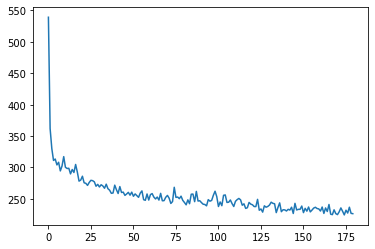

In [9]:
model.fit(train_ds, valid_ds, max_epochs=180, batch_size=batch_size , use_tensorboard=False,
          train_truth=train_ds, valid_truth=valid_ds)

## Load checkpoint with lowest validation error 

In [10]:
model.load_checkpoint('best')

## Plot results summary 

torch.Size([150, 20, 30])


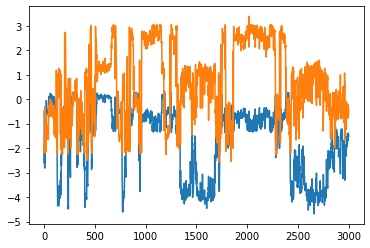

In [11]:
print(output_valid.shape)
#model.plot_factors()
tt = np.zeros((all_time,2))
gg = int(NRep/batch_size)
for k in range(gg):
    t = model.infer_factors(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(t)
    for i in range(batch_size):
        for j in range(Time):
            tt[(i+batch_size*k)*Time+j,:]=t[i][j].to('cpu').detach().numpy().copy()
plt.figure()
plt.plot(tt)

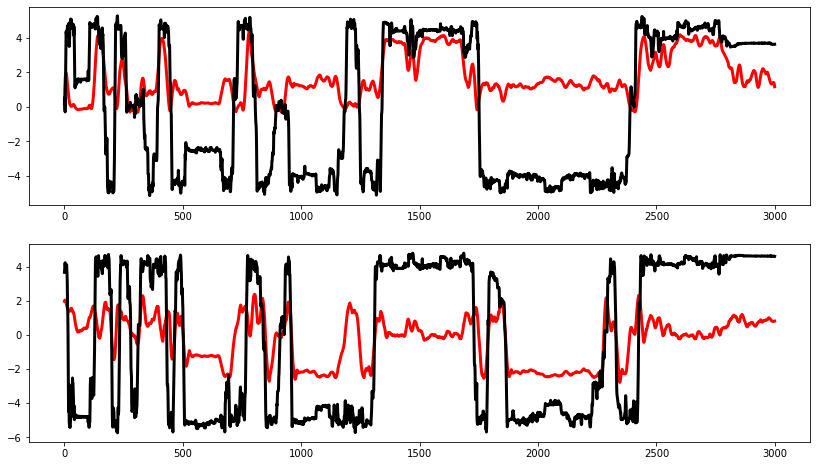

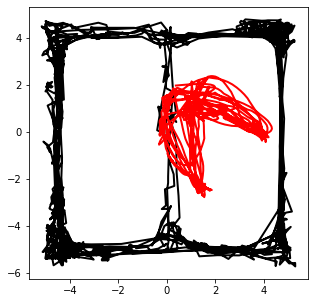

In [12]:
import funs
qz_mean_est = tt
#plt.plot(qz_mean_est[:,0])
qz_est_norm = qz_mean_est#np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
#plt.plot(qz_est_norm[:,0],qz_est_norm[:,1])
z_true_c = traj# - x_test.mean(axis=0)
z_true_norm = z_true_c#/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.figure(figsize=(14,8))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure(figsize=(5,5))
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], lw=2, color = 'r')